# Supernova Investigation: Coherence vs Shear

**The Core Question:** During the early training explosion ("supernova"), does the dead token cloud move coherently (preserving spongecrystal structure) or shear apart (destroying it)?

## Method

We work in **Cartesian W-space** (float32, natural units) to avoid mixing coordinate systems.

For each timestep:
1. **Individual motion**: ΔW = W(t+1) - W(t) (how each token moves)
2. **Bulk motion**: ΔC = mean(ΔW) (where the cloud's center of mass goes)
3. **Centered motion**: ΔW - ΔC (internal jitter/shear relative to the centroid)

If centered displacements are **small** relative to bulk motion → **coherent** → spongecrystal survives

If centered displacements are **large** → **shearing** → spongecrystal destroyed

We'll look at both Cartesian magnitudes (float32 units) and lattice-cell counts to understand the scale.

## Parameters

In [1]:
THIMBLE_PATH = "../tensors/Thimble/thimble_7.h5"
RANDOM_SEED = 42
HIST_BINS = 100
TIME_SLICES = [1, 5, 10, 50, 200, 1000]  # Snapshots from supernova through freeze
COLORMAP = 'inferno'

## Imports

In [2]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print(f"Loading data from {THIMBLE_PATH}...\n")

with h5py.File(THIMBLE_PATH, 'r') as f:
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    W_all = torch.from_numpy(f['W'][:]).view(torch.bfloat16)
    W_dead = W_all[:, dead_mask, :].to(torch.float32).to(device)
    
print(f"✓ Loaded W: {W_dead.shape}")
print(f"  {W_dead.shape[0]} timesteps, {W_dead.shape[1]} dead tokens, {W_dead.shape[2]} dims")
print(f"  Memory: ~{W_dead.element_size() * W_dead.numel() / 1e9:.2f} GB")

Loading data from ../tensors/Thimble/thimble_7.h5...

✓ Loaded W: torch.Size([6001, 3699, 64])
  6001 timesteps, 3699 dead tokens, 64 dims
  Memory: ~5.68 GB


## Compute Individual Motion (ΔW)

In [5]:
# Individual token displacement in Cartesian space
delta_W = W_dead[1:] - W_dead[:-1]  # [6000, 3699, 64]

print(f"✓ Computed ΔW: {delta_W.shape}")

✓ Computed ΔW: torch.Size([6000, 3699, 64])


## Compute Bulk Motion (ΔC)

In [6]:
# Bulk displacement: mean motion across all tokens
delta_C = delta_W.mean(dim=1)  # [6000, 64]

print(f"✓ Computed ΔC: {delta_C.shape}")

✓ Computed ΔC: torch.Size([6000, 64])


## Compute Centered Motion (ΔW - ΔC)

In [7]:
# Centered displacement: motion in the centroid's rest frame
# Broadcasting: [6000, 3699, 64] - [6000, 1, 64]
delta_W_centered = delta_W - delta_C.unsqueeze(1)

print(f"✓ Computed centered ΔW: {delta_W_centered.shape}")
print(f"  Memory: ~{delta_W_centered.element_size() * delta_W_centered.numel() / 1e9:.2f} GB")

✓ Computed centered ΔW: torch.Size([6000, 3699, 64])
  Memory: ~5.68 GB


## Compute Norms in Cartesian Space

L1, L2, L∞ for:
- Individual motion (ΔW)
- Bulk motion (ΔC)
- Centered motion (ΔW - ΔC)

In [8]:
# Bulk norms (per timestep)
bulk_L1 = torch.abs(delta_C).sum(dim=1).cpu().numpy()  # [6000]
bulk_L2 = torch.norm(delta_C, p=2, dim=1).cpu().numpy()  # [6000]
bulk_Linf = torch.abs(delta_C).max(dim=1).values.cpu().numpy()  # [6000]

print("✓ Bulk norms computed")
print(f"  L1 range: [{bulk_L1.min():.2e}, {bulk_L1.max():.2e}]")
print(f"  L2 range: [{bulk_L2.min():.2e}, {bulk_L2.max():.2e}]")
print(f"  L∞ range: [{bulk_Linf.min():.2e}, {bulk_Linf.max():.2e}]")

✓ Bulk norms computed
  L1 range: [0.00e+00, 6.27e-02]
  L2 range: [0.00e+00, 7.86e-03]
  L∞ range: [0.00e+00, 1.95e-03]


In [9]:
# Individual norms (per token per timestep)
individual_L1 = torch.abs(delta_W).sum(dim=2).cpu().numpy()  # [6000, 3699]
individual_L2 = torch.norm(delta_W, p=2, dim=2).cpu().numpy()  # [6000, 3699]
individual_Linf = torch.abs(delta_W).max(dim=2).values.cpu().numpy()  # [6000, 3699]

# Mean across tokens for comparison
mean_individual_L1 = individual_L1.mean(axis=1)
mean_individual_L2 = individual_L2.mean(axis=1)
mean_individual_Linf = individual_Linf.mean(axis=1)

print("✓ Individual norms computed")
print(f"  Mean L1 range: [{mean_individual_L1.min():.2e}, {mean_individual_L1.max():.2e}]")
print(f"  Mean L2 range: [{mean_individual_L2.min():.2e}, {mean_individual_L2.max():.2e}]")

✓ Individual norms computed
  Mean L1 range: [0.00e+00, 6.31e-02]
  Mean L2 range: [0.00e+00, 7.89e-03]


In [10]:
# Centered norms (per token per timestep)
centered_L1 = torch.abs(delta_W_centered).sum(dim=2).cpu().numpy()  # [6000, 3699]
centered_L2 = torch.norm(delta_W_centered, p=2, dim=2).cpu().numpy()  # [6000, 3699]
centered_Linf = torch.abs(delta_W_centered).max(dim=2).values.cpu().numpy()  # [6000, 3699]

# Mean across tokens
mean_centered_L1 = centered_L1.mean(axis=1)
mean_centered_L2 = centered_L2.mean(axis=1)
mean_centered_Linf = centered_Linf.mean(axis=1)

print("✓ Centered norms computed")
print(f"  Mean L1 range: [{mean_centered_L1.min():.2e}, {mean_centered_L1.max():.2e}]")
print(f"  Mean L2 range: [{mean_centered_L2.min():.2e}, {mean_centered_L2.max():.2e}]")

✓ Centered norms computed
  Mean L1 range: [0.00e+00, 1.17e-02]
  Mean L2 range: [0.00e+00, 3.27e-03]


## Plot: Bulk vs Centered Motion Over Time

**Key comparison**: How big is the centered motion (internal shear) relative to bulk motion (cloud displacement)?

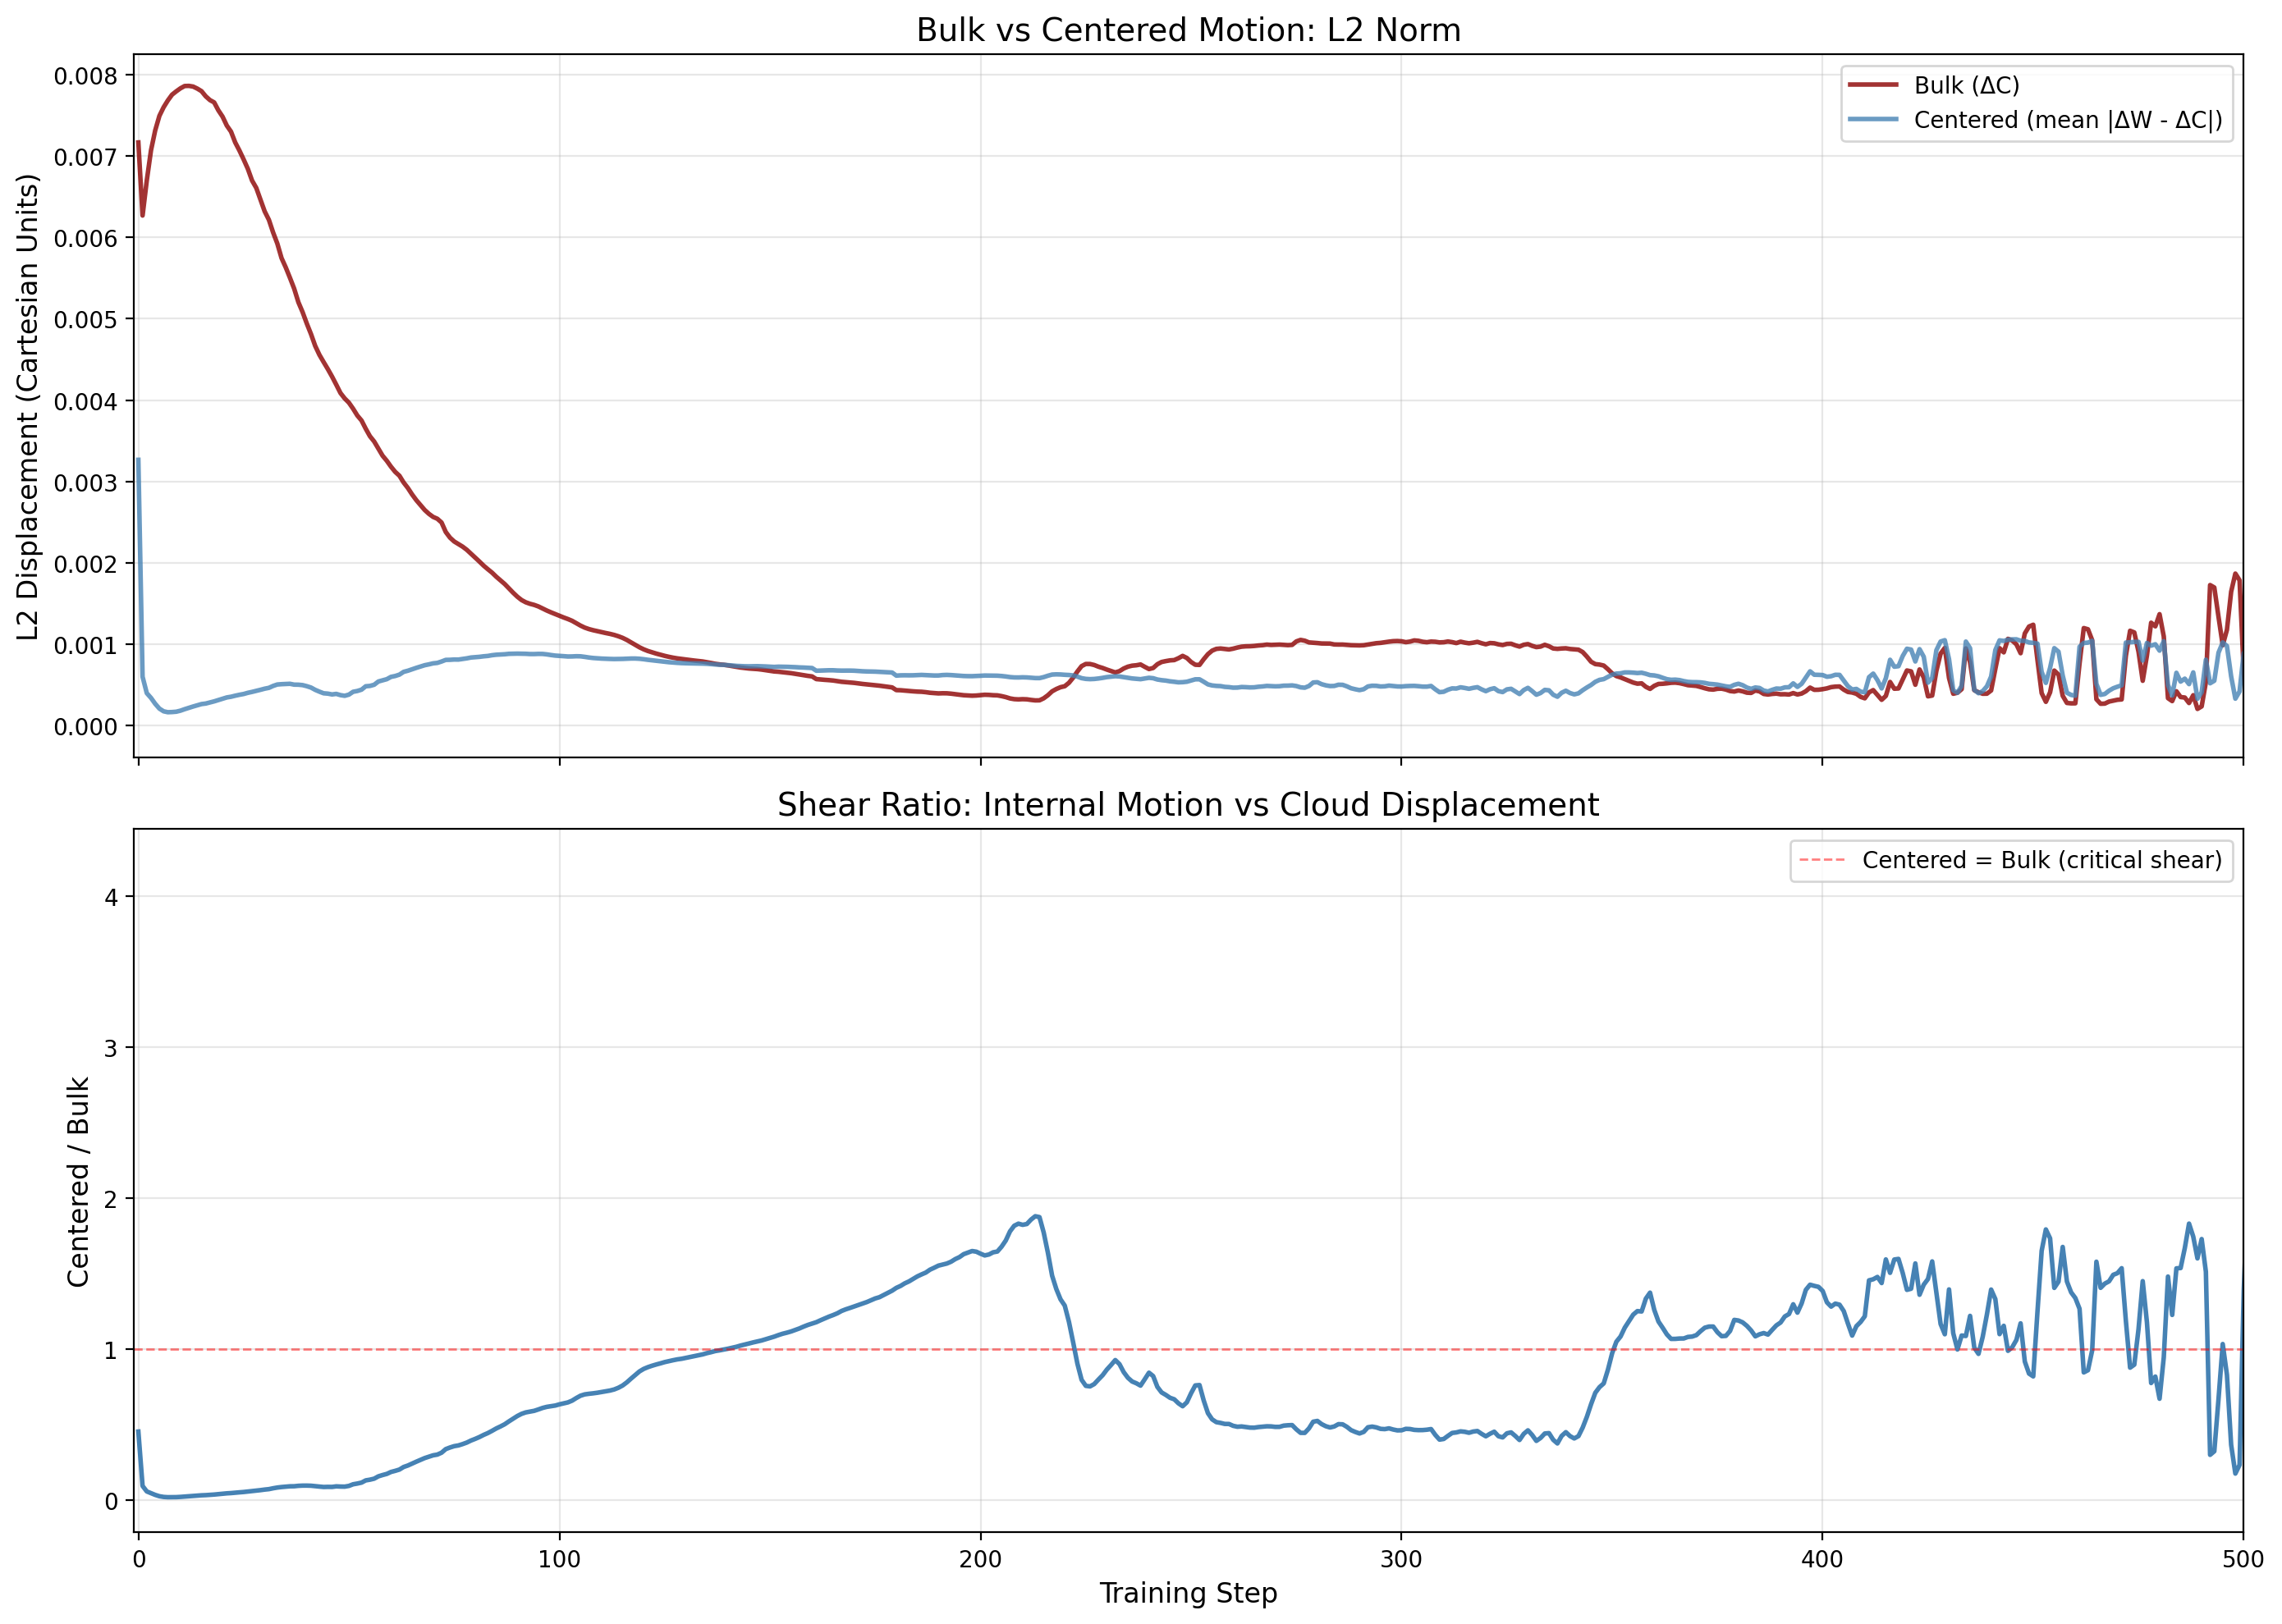

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=200, sharex=True)

# Top: L2 norms
ax1.plot(bulk_L2, label='Bulk (ΔC)', linewidth=2, alpha=0.8, color='darkred')
ax1.plot(mean_centered_L2, label='Centered (mean |ΔW - ΔC|)', linewidth=2, alpha=0.8, color='steelblue')
ax1.set_ylabel('L2 Displacement (Cartesian Units)', fontsize=12)
ax1.set_title('Bulk vs Centered Motion: L2 Norm', fontsize=14)
ax1.legend(loc='best')
ax1.grid(alpha=0.3)
ax1.set_yscale('linear')

ax1.set_xlim(left=-1, right=500)

# Bottom: Ratio (shear / bulk)
ratio = mean_centered_L2 / (bulk_L2 + 1e-30)
ax2.plot(ratio, linewidth=2, color='steelblue')
ax2.axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Centered = Bulk (critical shear)')
ax2.set_xlabel('Training Step', fontsize=12)
ax2.set_ylabel('Centered / Bulk', fontsize=12)
ax2.set_title('Shear Ratio: Internal Motion vs Cloud Displacement', fontsize=14)
ax2.legend(loc='best')
ax2.grid(alpha=0.3)
ax2.set_yscale('linear')

ax2.set_xlim(left=-1, right=500)

plt.tight_layout()
plt.show()

## Interpretation

If ratio << 1: **Coherent motion** (tokens move together, spongecrystal survives)

If ratio ≈ 1: **Critical shear** (internal motion comparable to bulk, structure threatened)

If ratio >> 1: **Shearing apart** (tokens flying apart, spongecrystal destroyed)

## Histogram Evolution: Centered Motion Distribution

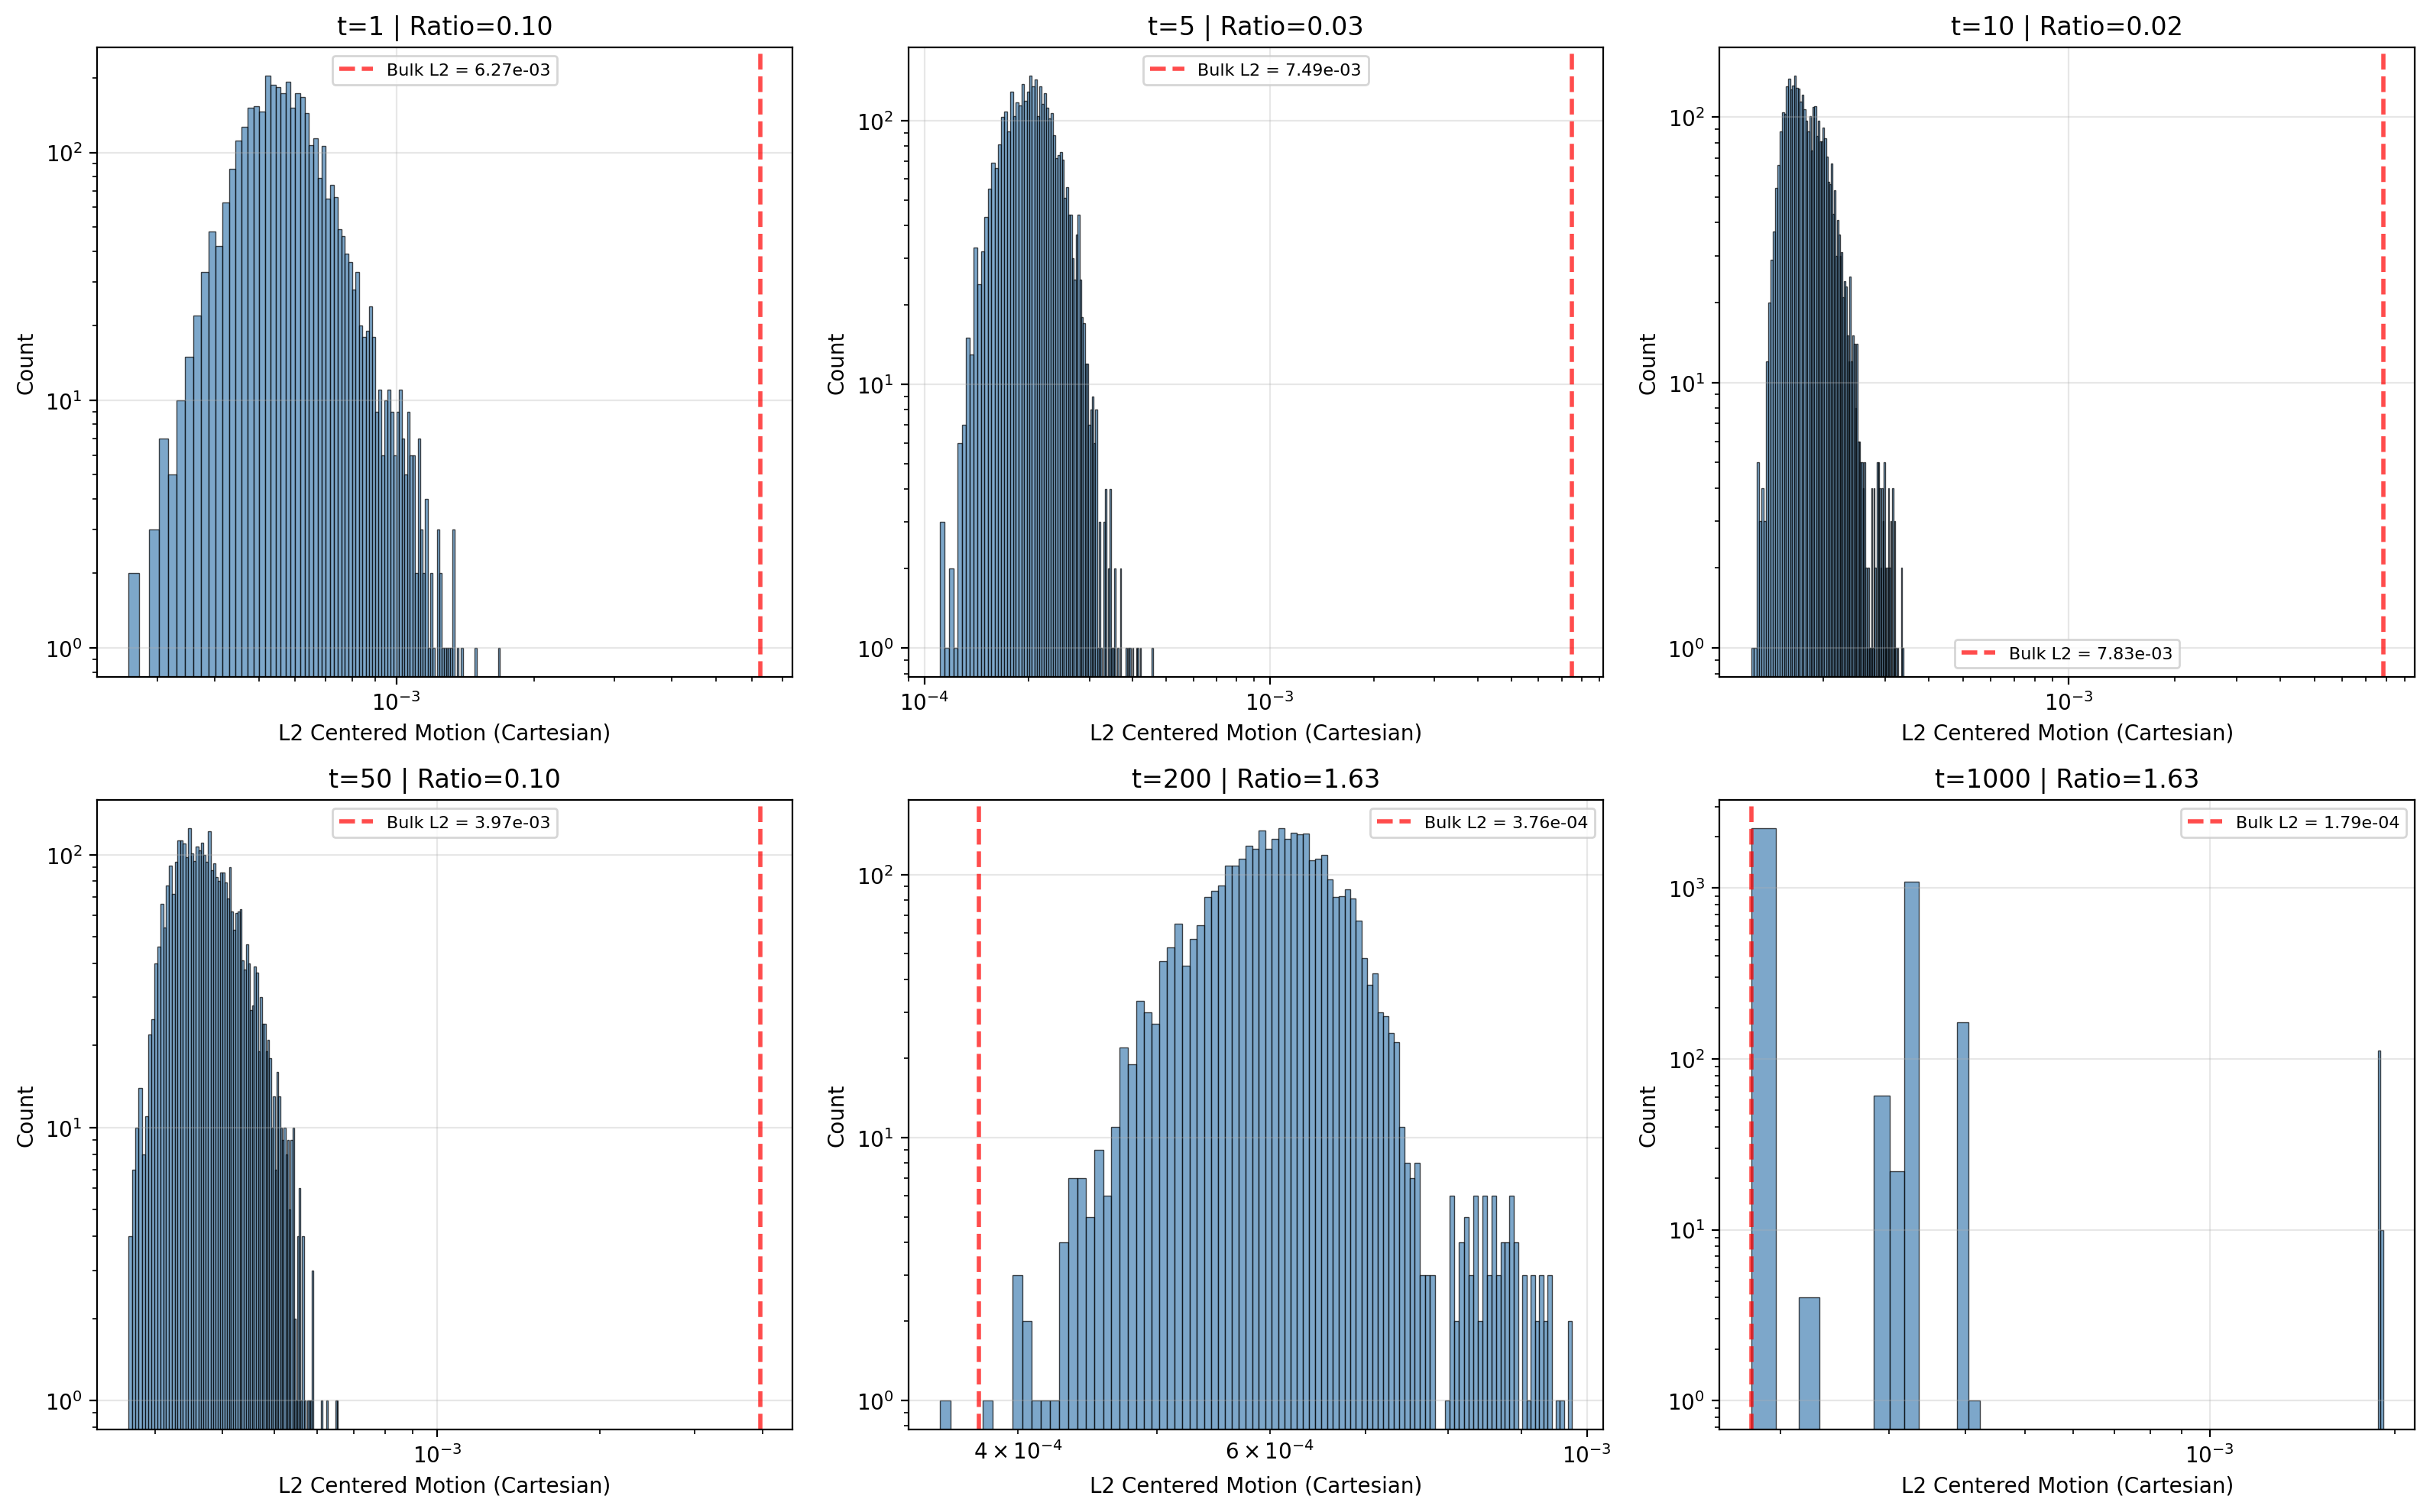

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=200)
axes = axes.flatten()

for idx, t in enumerate(TIME_SLICES):
    if t >= len(centered_L2):
        axes[idx].text(0.5, 0.5, f't={t}\n(out of range)', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        continue
    
    # L2 centered motion histogram at this timestep
    data = centered_L2[t, :]
    
    # Reference: bulk motion at this timestep
    bulk_val = bulk_L2[t]
    
    axes[idx].hist(data, bins=HIST_BINS, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    axes[idx].axvline(bulk_val, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Bulk L2 = {bulk_val:.2e}')
    axes[idx].set_xlabel('L2 Centered Motion (Cartesian)')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f't={t} | Ratio={mean_centered_L2[t]/bulk_val:.2f}')
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xscale('log')
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.show()

## Optional: Convert to Lattice Units

How many lattice cells do these Cartesian displacements represent?

In [28]:
def compute_ulp(x):
    """Compute ULP for bfloat16-represented values in float32."""
    ulp_pos = torch.nextafter(x, x + torch.ones_like(x)) - x
    ulp_neg = x - torch.nextafter(x, x - torch.ones_like(x))
    ulp = torch.where(x >= 0, ulp_pos, ulp_neg)
    return ulp.abs()

# ULP at each token position (start of each step)
U_tokens = compute_ulp(W_dead[:-1])  # [6000, 3699, 64]

# Convert centered motion to lattice coordinates
delta_W_centered_lattice = delta_W_centered / (U_tokens + 1e-30)

# L1 norm in lattice space
centered_L1_lattice = torch.abs(delta_W_centered_lattice).sum(dim=2).cpu().numpy()
mean_centered_L1_lattice = centered_L1_lattice.mean(axis=1)

print("✓ Converted centered motion to lattice coordinates")
print(f"  Mean L1 lattice range: [{mean_centered_L1_lattice.min():.2e}, {mean_centered_L1_lattice.max():.2e}] cells")

✓ Converted centered motion to lattice coordinates
  Mean L1 lattice range: [0.00e+00, 1.58e+22] cells


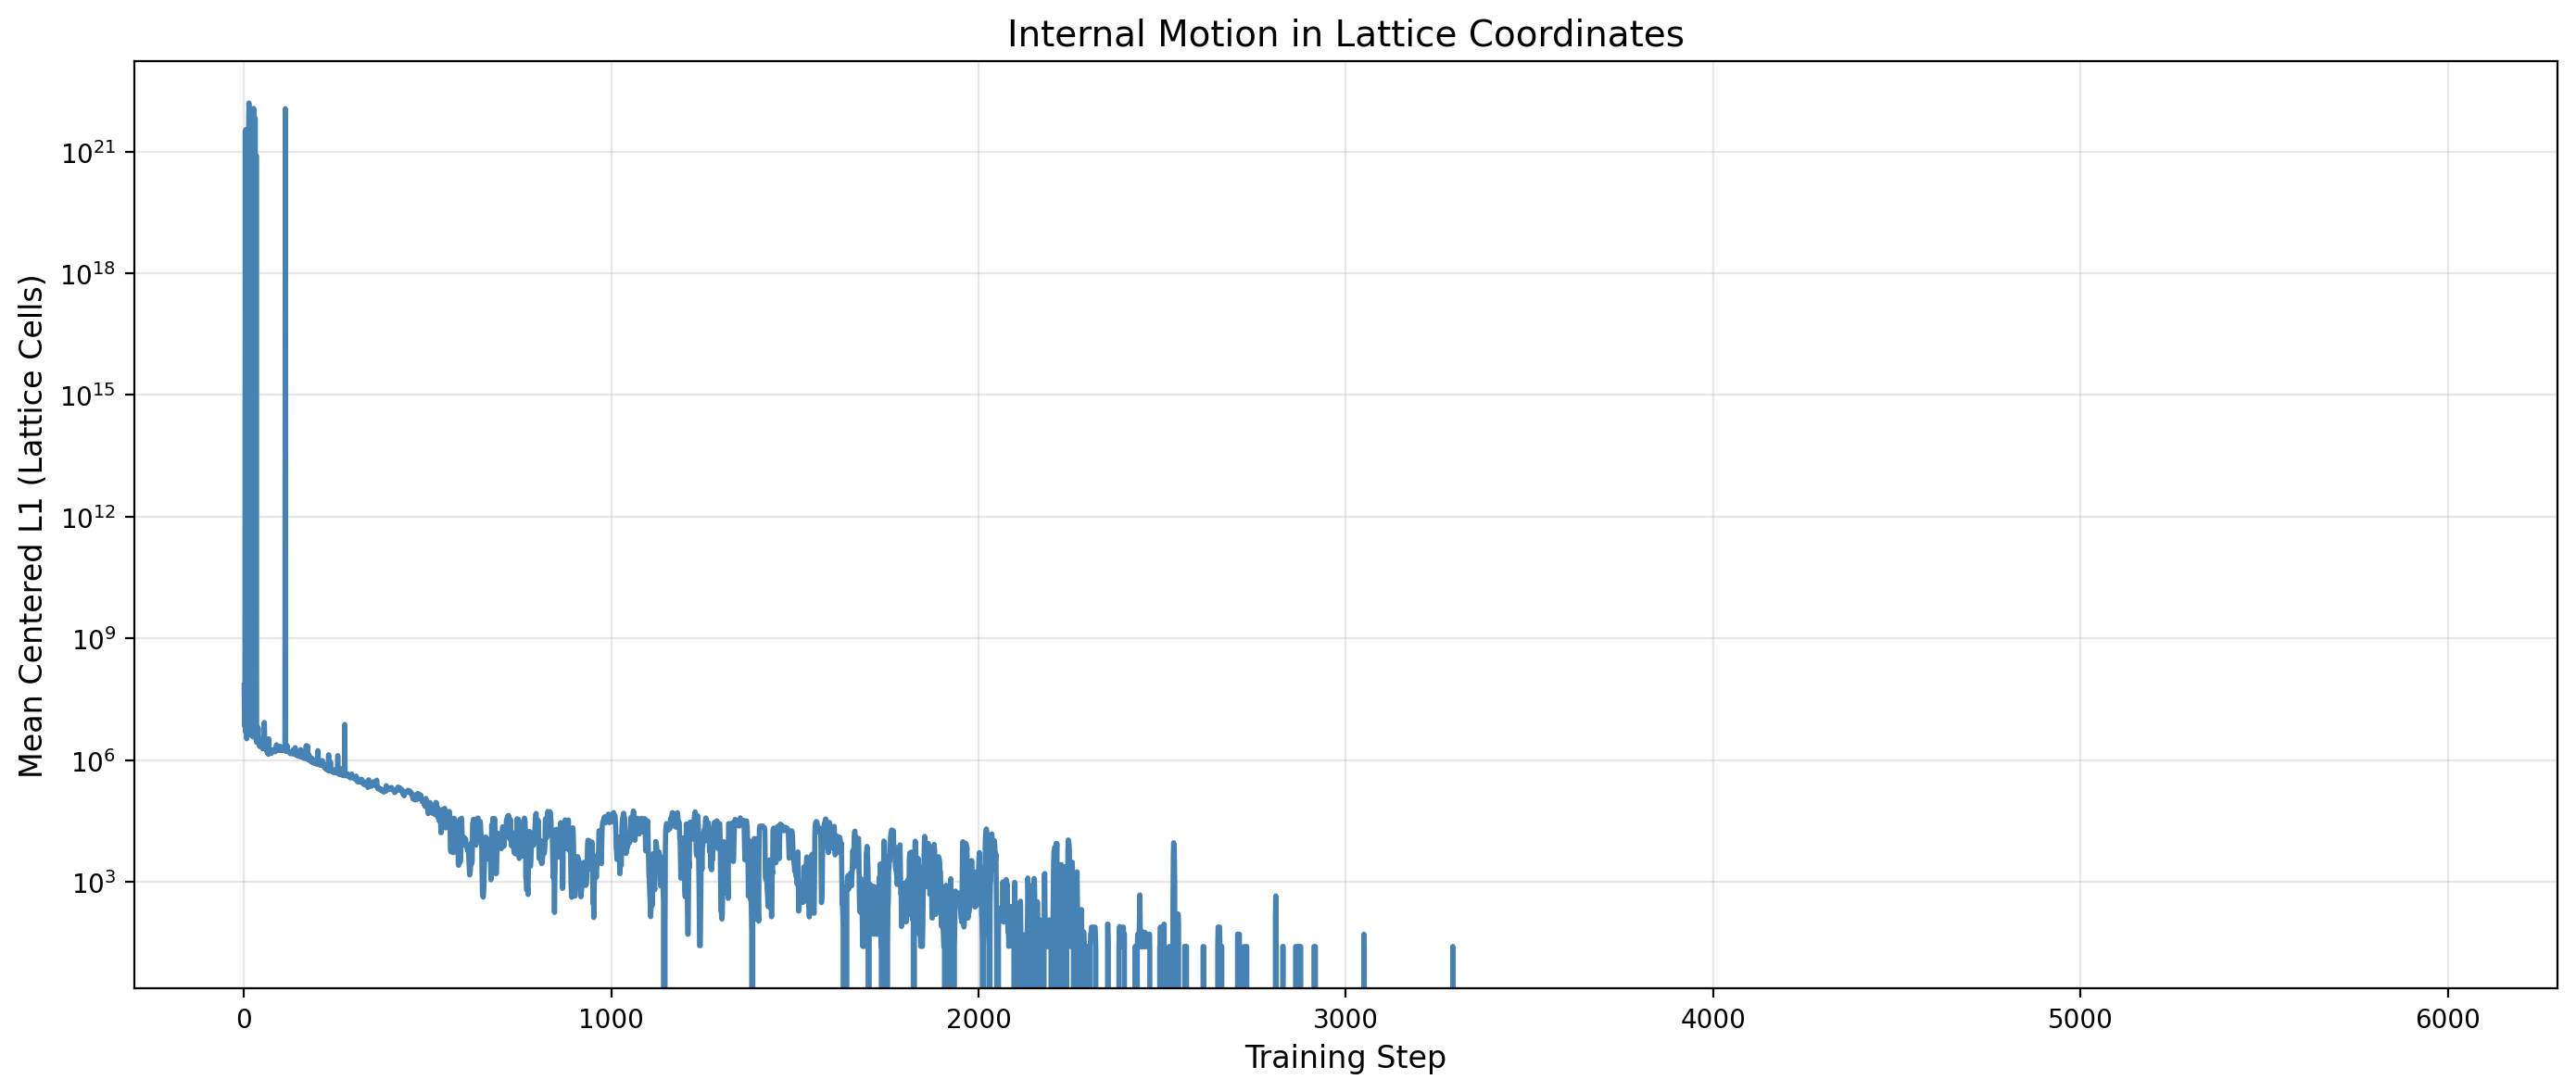

In [29]:
# Plot centered motion in lattice units
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)

ax.plot(mean_centered_L1_lattice, color='steelblue', linewidth=2)
ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Mean Centered L1 (Lattice Cells)', fontsize=12)
ax.set_title('Internal Motion in Lattice Coordinates', fontsize=14)
ax.grid(alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

## Summary Statistics

In [30]:
# Supernova phase (first 100 steps)
supernova_bulk = bulk_L2[:100].mean()
supernova_centered = mean_centered_L2[:100].mean()
supernova_ratio = supernova_centered / supernova_bulk

# Mid phase
mid_bulk = bulk_L2[500:2000].mean()
mid_centered = mean_centered_L2[500:2000].mean()
mid_ratio = mid_centered / mid_bulk

# Late phase
late_bulk = bulk_L2[2000:].mean()
late_centered = mean_centered_L2[2000:].mean()
late_ratio = late_centered / (late_bulk + 1e-30)

print("=" * 80)
print("SUPERNOVA INVESTIGATION: COHERENCE vs SHEAR")
print("=" * 80)
print()
print("Supernova Phase (t=0-100):")
print(f"  Bulk motion (L2):      {supernova_bulk:.2e} units")
print(f"  Centered motion (L2):  {supernova_centered:.2e} units")
print(f"  Shear ratio:           {supernova_ratio:.2f}")
print()
print("Mid Phase (t=500-2000):")
print(f"  Bulk motion (L2):      {mid_bulk:.2e} units")
print(f"  Centered motion (L2):  {mid_centered:.2e} units")
print(f"  Shear ratio:           {mid_ratio:.2f}")
print()
print("Late Phase (t=2000+):")
print(f"  Bulk motion (L2):      {late_bulk:.2e} units")
print(f"  Centered motion (L2):  {late_centered:.2e} units")
print(f"  Shear ratio:           {late_ratio:.2f}")
print()
print("=" * 80)
print("INTERPRETATION:")
print("=" * 80)
if supernova_ratio < 0.5:
    print("✓ COHERENT: Tokens move together during supernova (ratio < 0.5)")
    print("  → Spongecrystal structure likely SURVIVES early training")
elif supernova_ratio < 1.0:
    print("⚠ MODERATE SHEAR: Internal motion comparable to bulk (0.5 < ratio < 1)")
    print("  → Spongecrystal structure MAY be distorted but not destroyed")
else:
    print("✗ SHEARING APART: Internal motion exceeds bulk (ratio > 1)")
    print("  → Spongecrystal structure likely DESTROYED during supernova")
print("=" * 80)

SUPERNOVA INVESTIGATION: COHERENCE vs SHEAR

Supernova Phase (t=0-100):
  Bulk motion (L2):      4.43e-03 units
  Centered motion (L2):  5.84e-04 units
  Shear ratio:           0.13

Mid Phase (t=500-2000):
  Bulk motion (L2):      1.36e-04 units
  Centered motion (L2):  1.39e-04 units
  Shear ratio:           1.02

Late Phase (t=2000+):
  Bulk motion (L2):      3.20e-07 units
  Centered motion (L2):  6.09e-07 units
  Shear ratio:           1.90

INTERPRETATION:
✓ COHERENT: Tokens move together during supernova (ratio < 0.5)
  → Spongecrystal structure likely SURVIVES early training
